### Random Forest
- La Morgia

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import OneClassSVM

In [2]:
def check(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    Y = df['gt'].astype(int).values.ravel()

    from collections import Counter
    label_counts = Counter(Y)

    print('Processing: time freq {}'.format(time_freq))
    print("The number of each category label in Y is:")
    for label, count in label_counts.items():
        print(label, ":", count)


check(time_freq='25S')
check(time_freq='15S')
check(time_freq='5S')

Processing: time freq 25S
The number of each category label in Y is:
0 : 481840
1 : 317
Processing: time freq 15S
The number of each category label in Y is:
0 : 583787
1 : 317
Processing: time freq 5S
The number of each category label in Y is:
0 : 820990
1 : 317


In [ ]:
def classifier(time_freq):

    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=2023)
    #clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.5, random_state=0)
    
    cv_list = [5]
    processes = 7

    for n_fold in cv_list:
        print('Processing: {} folds - time freq {}'.format(n_fold, time_freq))
        y_pred = cross_val_predict(clf, X, Y.ravel(), cv=StratifiedKFold(n_splits=n_fold), n_jobs=processes)
        print(f'Fitting model for {time_freq}.')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y.ravel(), train_size=0.8,stratify=Y, random_state=2023)
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        print('Recall: {}'.format(recall_score(Y_test, y_pred)))
        print('Precision: {}'.format(precision_score(Y_test, y_pred)))
        print('F1 score: {}'.format(f1_score(Y_test, y_pred)))

    if time_freq=='25S':
        # Get feature importances
        importances = clf.feature_importances_

        # Sort feature importances and corresponding feature names
        indices = np.argsort(importances)[::-1]
        sorted_feature_names = [features[i] for i in indices]

        # 绘制柱状图
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importances[indices], y=sorted_feature_names)
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        plt.title('Random Forest Classifier - Feature Importance')
        plt.show()

In [ ]:
start = datetime.datetime.now()
classifier(time_freq='25S')
classifier(time_freq='15S')
classifier(time_freq='5S')
print(datetime.datetime.now() - start)

In [ ]:
def ocsvm(time_freq):
    print('Processing: time freq {}'.format(time_freq))

    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # clf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=2023)
    # clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), n_estimators=100, learning_rate=0.5, random_state=0)
    
    # split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y , random_state=2023)

    # define model
    clf = OneClassSVM(kernel='rbf', nu=0.1, gamma=0.1)

    # train on normal data
    trainX = X_train[y_train == 0]

    # fit model
    clf.fit(trainX)

    # predict on trian set
    y_pred_train = clf.predict(X_train)
    print('Recall: {}'.format(recall_score(y_train, y_pred_train)))
    print('Precision: {}'.format(precision_score(y_train, y_pred_train)))
    print('F1 score: {}'.format(f1_score(y_train, y_pred_train)))

    # predict on test set
    y_pred_test = clf.predict(X_test)
    print('Recall: {}'.format(recall_score(y_test, y_pred_test)))
    print('Precision: {}'.format(precision_score(y_test, y_pred_test)))
    print('F1 score: {}'.format(f1_score(y_test, y_pred_test)))

    # get the prediction labels
    y_pred = clf.predict(X_train)

    # get the indices of the outliers
    outliers = np.where(y_pred == -1)

    # anomaly scores
    y_pred_outliers = clf.decision_function(X_train)
    y_pred_outliers = pd.Series(y_pred_outliers)
    y_pred_outliers = y_pred_outliers.sort_values(ascending=True)
    print(y_pred_outliers)

    # plot the prediction scores
    plt.figure(figsize=(10, 6))
    plt.hist(y_pred_outliers, bins=50)
    plt.xlabel('Outlier Score')
    plt.ylabel('Number of Outliers')
    plt.title('OCSVM - Outlier Scores')
    plt.show()

In [ ]:
start = datetime.datetime.now()
ocsvm(time_freq='25S')
ocsvm(time_freq='15S')
ocsvm(time_freq='5S')
print(datetime.datetime.now() - start)

### Function

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def train_test(time_freq):
    # 读取数据
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])
    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    # 特征和标签
    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # 标准化特征
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # SMOTE过采样
    # from imblearn.over_sampling import SMOTE
    # sm = SMOTE(random_state=2023)
    # X_resampled, y_resampled = sm.fit_sample(X, Y)

    # 划分数据集为训练集和测试集
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2023,stratify=Y)

    return X_train, X_test, y_train, y_test

### C-LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed, Input, Conv1D, Conv2D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization

In [ ]:
X_train, X_test, y_train, y_test = train_test(time_freq='25S')

# timestamps
def to_sequences(x,y,seq_size):
    x = pd.DataFrame(x)
    y = pd.Series(y)
    x_values = []
    y_values = []
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
    return np.array(x_values), np.array(y_values)

seq_size=30
trainX, trainY = to_sequences(X_train,y_train,seq_size)
testX, testY = to_sequences(X_test,y_test,seq_size)\

input = Input(shape=(trainX.shape[1],trainX.shape[2]))    # samples, time steps, features
x=TimeDistributed(Conv2D(16, kernel_size=3, activation='relu'))(input)
x=TimeDistributed(MaxPooling2D(pool_size=2))(x)
x=TimeDistributed(Flatten())(x)
x=LSTM(200, return_sequences=True)(x)
outputs = Dense(1)(x)
cnn_lstm = Model(inputs=input, outputs=outputs)
cnn_lstm.compile(loss='mae', optimizer='adam')
cnn_lstm.summary()

In [ ]:
def create_cnn_lstm_model(input_shape):
    # 输入层
    input = Input(shape=input_shape)

    # CNN层
    # x=TimeDistributed(Conv1D(4, kernel_size=3, activation='relu'))(input)
    # x=TimeDistributed(MaxPooling1D(pool_size=2))(x)
    # x=TimeDistributed(Flatten())(x)

    x = Conv1D(4, kernel_size=3, activation='relu')(input)
    x = MaxPooling1D(pool_size=2)(x)

    # CNN层
    x = Conv1D(8, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)

    # LSTM层
    x = LSTM(8)(x)
    # x = Dropout(0.2)(x)
    
    # 输出层
    outputs = Dense(1)(x)
  
    model = Model(inputs=input, outputs=outputs)
    model.compile(loss='mae', optimizer='adam')
    model.summary()

    return model
    
# time_steps = 100
# n_features = 12
# input_shape = (time_steps, n_features)

input_shape = (12, 1)
model = create_cnn_lstm_model(input_shape)

In [ ]:
def cnn_lstm(model,time_freq):
    X_train, X_test, y_train, y_test = train_test(time_freq=time_freq)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # 训练模型
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    history = model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, batch_size=32, epochs=100, validation_split=0.1, callbacks=[early_stopping])

    # loss曲线
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('CNN-LSTM Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # predict
    y_pred = model.predict(X_test.reshape(-1, X_test.shape[1], 1))
    y_pred = np.where(y_pred > 0.5, 1, 0)

    # evaluate
    from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
    print('Recall: {}'.format(recall_score(y_test, y_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_pred)))
    print('F1 score: {}'.format(f1_score(y_test, y_pred)))

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('CNN-LSTM Model - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

- 25s

In [ ]:
cnn_lstm(model,time_freq='25S')

- 15s

In [ ]:
cnn_lstm(model,time_freq='15S')

- 5s

In [ ]:
cnn_lstm(model,time_freq='5S')

# LSTM AutoEncoder

In [115]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Input, Dropout, Dense, RepeatVector, TimeDistributed
from keras import regularizers
from tensorflow.keras.models import Model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

In [114]:
# --------------------------------------------------------------------------------------------------
def lstm_autoencoder(time_freq):
    df = pd.read_csv('labeled_features/features_' + time_freq + '.csv', parse_dates=['date'])

    features = ['std_rush_order',
                'avg_rush_order',
                'std_trades',
                'std_volume',
                'avg_volume',
                'std_price',
                'avg_price',
                'avg_price_max',
                'hour_sin',
                'hour_cos',
                'minute_sin',
                'minute_cos']

    X = df[features]
    Y = df['gt'].astype(int).values.ravel()

    # normalize
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # normal data
    X_normal = X[Y == 0]
    Y_normal = Y[Y == 0]

    # abnormal data
    X_abnormal = X[Y == 1]
    Y_abnormal = Y[Y == 1]

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=2023)
    
    # 拼接X_test和X_abnormal
    X_test = np.concatenate((X_test, X_abnormal), axis=0)
    y_test = np.concatenate((y_test, Y_abnormal), axis=0)

    # 将时间序列数据转换为适用于LSTM自编码器的输入格式
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # 构建LSTM自编码器模型
    reg = 0.0001
    inputs = Input(shape=(X_train.shape[1],X_train.shape[2]))
    encoded = LSTM(32, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(reg))(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
    decoded = RepeatVector(X_train.shape[1])(encoded)
    decoded = LSTM(16, activation='relu', return_sequences=True,)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(X_train.shape[2]))(decoded)
    autoencoder = Model(inputs, outputs)
    autoencoder.compile(optimizer='adam', loss='mae')
    # adam = optimizers.Adam(learning_rate=0.0001)
    # autoencoder.compile(optimizer=adam, loss='mae')
    # autoencoder.summary()

    # 使用训练数据训练LSTM自编码器模型
    early_stopping = EarlyStopping(monitor='val_loss', patience=12, verbose=2, restore_best_weights=True)
    history= autoencoder.fit(X_train, X_train
                            , epochs=150
                            , batch_size=32
                            , validation_split=0.1
                            , callbacks=[early_stopping]
                            )

    # plot loss curve
    fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
    ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
    ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
    ax.set_title('LSTM-AutoEncoder Model loss', fontsize=16)
    ax.set_ylabel('Loss (mae)')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')
    plt.show()

    # 使用训练好的LSTM自编码器重构测试数据
    X_test_pred = autoencoder.predict(X_test)
    X_test_pred = X_test_pred.reshape(X_test_pred.shape[0], X_test_pred.shape[2])
    testX = X_test.reshape(X_test.shape[0], X_test.shape[2])

    # 计算还原误差MAE
    test_mae = np.mean(np.abs(testX - X_test_pred), axis=1)

    return autoencoder, test_mae, y_test



# --------------------------------------------------------------------------------------------------
def pick_threshold(y, preds):
    thresholds = np.linspace(0, 1, 1000)
    f1_scores = [f1_score(y, preds > t) for t in thresholds]
    precision_scores = [precision_score(y, preds > t) for t in thresholds]
    recall_scores = [recall_score(y, preds > t) for t in thresholds]
    plt.figure(figsize=(12, 6))
    plt.plot(thresholds, f1_scores, label='F1 Score')
    plt.plot(thresholds, precision_scores, label='Precision')
    plt.plot(thresholds, recall_scores, label='Recall')
    plt.axvline(x=thresholds[np.argmax(f1_scores)], color='r', linestyle='--', label='Max F1 Score')
    plt.title('F1 Score w.r.t varying threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()
    best_threshold = thresholds[np.argmax(f1_scores)]
    print('Best threshold: ', best_threshold)
    print('Best F1 Score: ', np.max(f1_scores))
    print('Recall: ', recall_score(y, preds > best_threshold))
    print('Precision: ', precision_score(y, preds > best_threshold))
    

    cm = confusion_matrix(y, preds > best_threshold)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    return best_threshold
# ------------------------------set threshold--------------------------------------------------------
def set_threshold(y_test, test_mae, threshold):
    # 设置阈值
    threshold = threshold
    print("Reconstruction error threshold: ", threshold)
    y_test_pred = np.where(test_mae >= threshold , 1, 0)

    # precision, recall, f1-score
    print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))
    print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
    print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
    

    # plot confusion matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title('LSTM-AutoEncoder - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


- 25S

Epoch 1/150
10842/10842 [==============================] - 31s 3ms/step - loss: 0.1165 - val_loss: 0.0638
Epoch 2/150
10842/10842 [==============================] - 26s 2ms/step - loss: 0.0546 - val_loss: 0.0292
Epoch 3/150
10842/10842 [==============================] - 24s 2ms/step - loss: 0.0238 - val_loss: 0.0229
Epoch 4/150
10842/10842 [==============================] - 24s 2ms/step - loss: 0.0220 - val_loss: 0.0221
Epoch 5/150
10842/10842 [==============================] - 24s 2ms/step - loss: 0.0209 - val_loss: 0.0209
Epoch 6/150
10842/10842 [==============================] - 26s 2ms/step - loss: 0.0204 - val_loss: 0.0193
Epoch 7/150
10842/10842 [==============================] - 25s 2ms/step - loss: 0.0200 - val_loss: 0.0209
Epoch 8/150
10842/10842 [==============================] - 25s 2ms/step - loss: 0.0197 - val_loss: 0.0207
Epoch 9/150
10842/10842 [==============================] - 25s 2ms/step - loss: 0.0194 - val_loss: 0.0192
Epoch 10/150
10842/10842 [====================

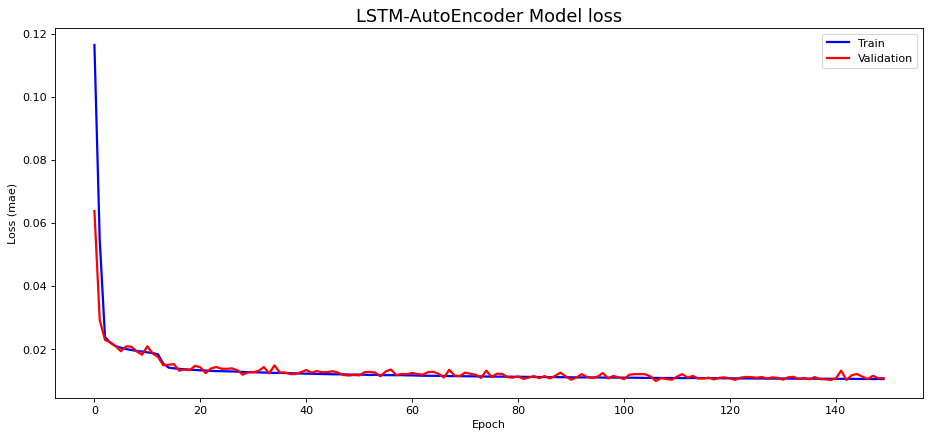

3022/3022 [==============================] - 3s 926us/step


In [116]:
autoencoder_25S, test_mae_25S, y_test_25S = lstm_autoencoder(time_freq='25S')

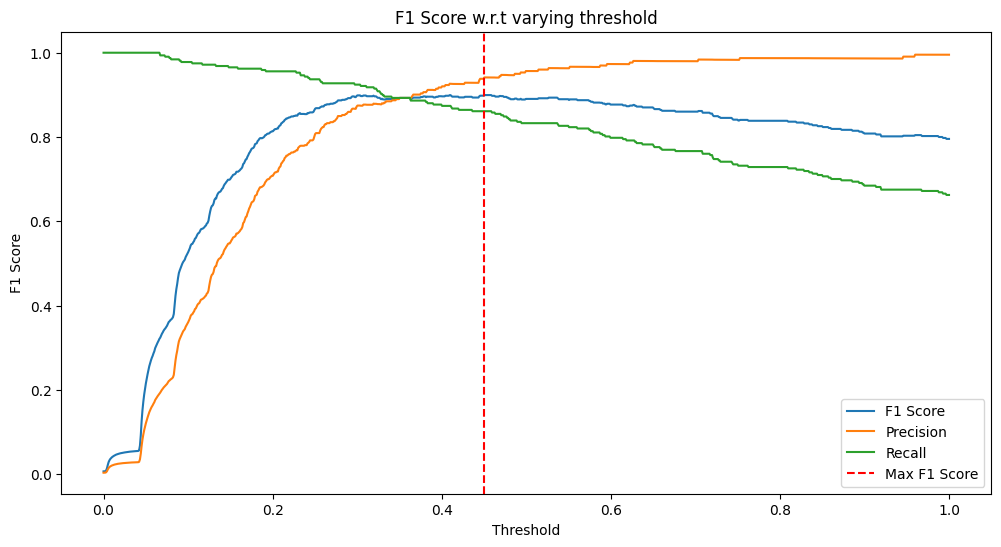

Best threshold:  0.45045045045045046
Best F1 Score:  0.8995057660626029
Recall:  0.861198738170347
Precision:  0.9413793103448276


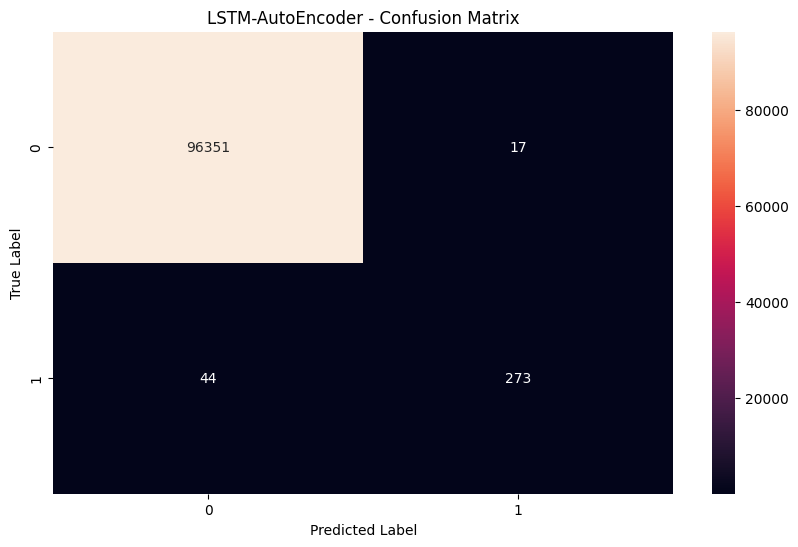

In [117]:
threshold_25S = pick_threshold(y_test_25S, test_mae_25S)

Reconstruction error threshold:  0.45045045045045046
F1 score: 0.8995057660626029
Recall: 0.861198738170347
Precision: 0.9413793103448276


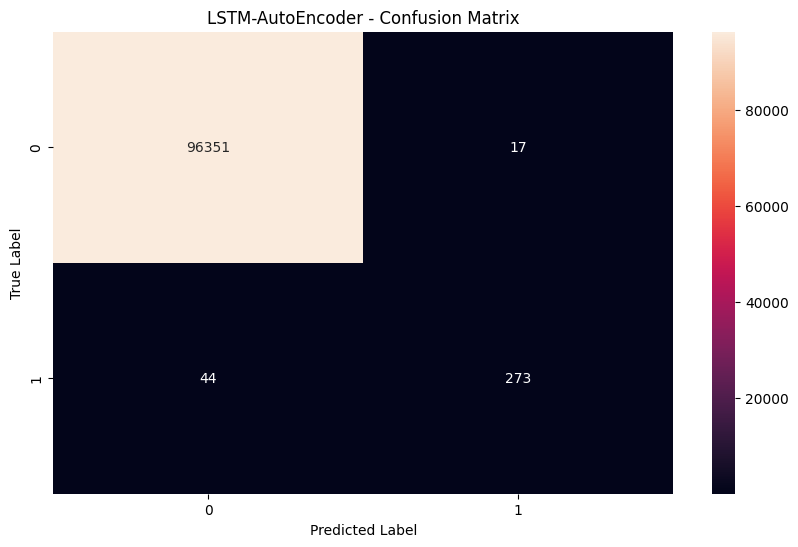

In [118]:
threshold = threshold_25S
set_threshold(y_test_25S, test_mae_25S, threshold)

- 15S

Epoch 1/150
13136/13136 [==============================] - 40s 3ms/step - loss: 0.2239 - val_loss: 0.0836
Epoch 2/150
13136/13136 [==============================] - 32s 2ms/step - loss: 0.0831 - val_loss: 0.0822
Epoch 3/150
13136/13136 [==============================] - 34s 3ms/step - loss: 0.0822 - val_loss: 0.0817
Epoch 4/150
13136/13136 [==============================] - 59s 5ms/step - loss: 0.0818 - val_loss: 0.0813
Epoch 5/150
13136/13136 [==============================] - 60s 5ms/step - loss: 0.0816 - val_loss: 0.0810
Epoch 6/150
13136/13136 [==============================] - 58s 4ms/step - loss: 0.0769 - val_loss: 0.0579
Epoch 7/150
13136/13136 [==============================] - 39s 3ms/step - loss: 0.0571 - val_loss: 0.0563
Epoch 8/150
13136/13136 [==============================] - 37s 3ms/step - loss: 0.0563 - val_loss: 0.0553
Epoch 9/150
13136/13136 [==============================] - 59s 5ms/step - loss: 0.0558 - val_loss: 0.0545
Epoch 10/150
13136/13136 [====================

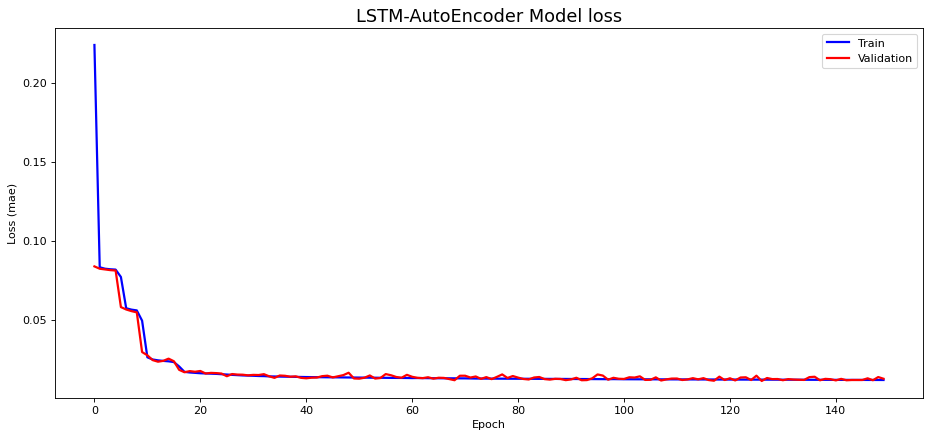

3659/3659 [==============================] - 4s 955us/step


In [119]:
autoencoder_15S, test_mae_15S, y_test_15S = lstm_autoencoder(time_freq='15S')

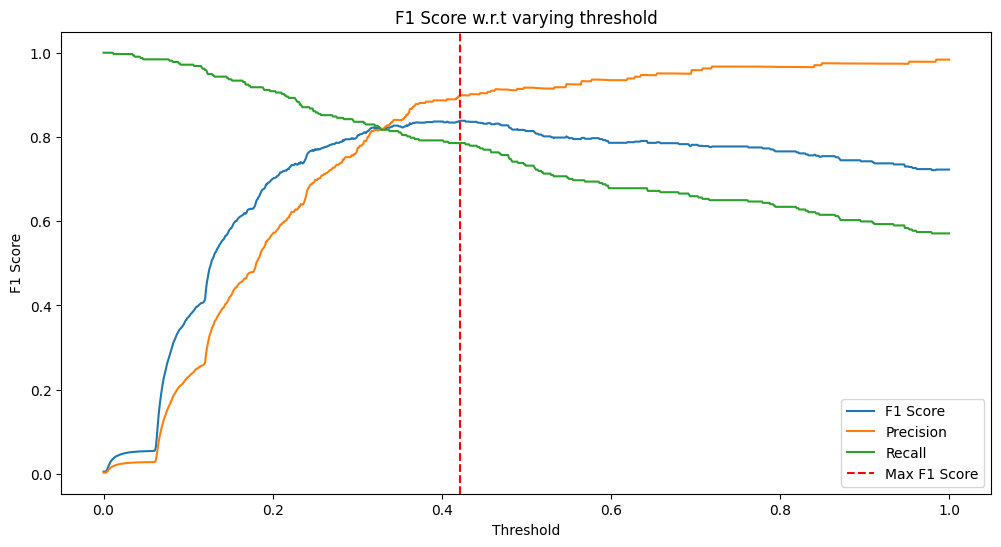

Best threshold:  0.4214214214214214
Best F1 Score:  0.8383838383838385
Recall:  0.7854889589905363
Precision:  0.8989169675090253


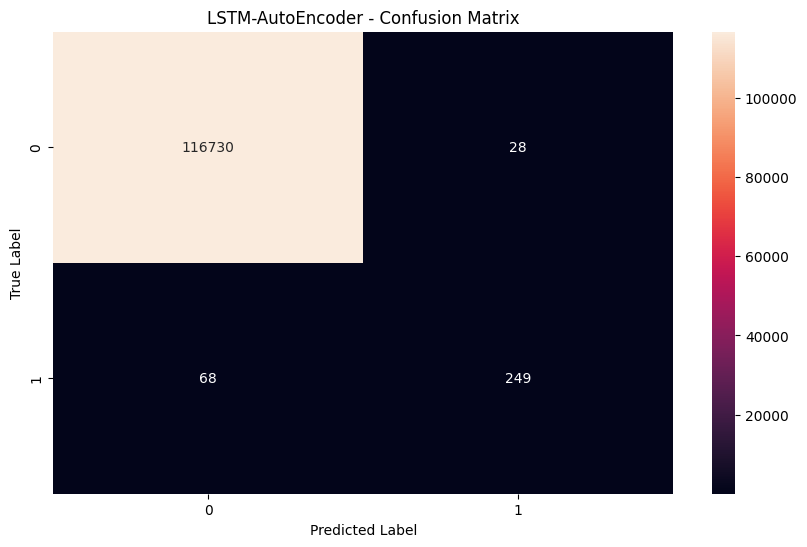

In [120]:
threshold_15S = pick_threshold(y_test_15S, test_mae_15S)

Reconstruction error threshold:  0.4214214214214214
F1 score: 0.8383838383838385
Recall: 0.7854889589905363
Precision: 0.8989169675090253


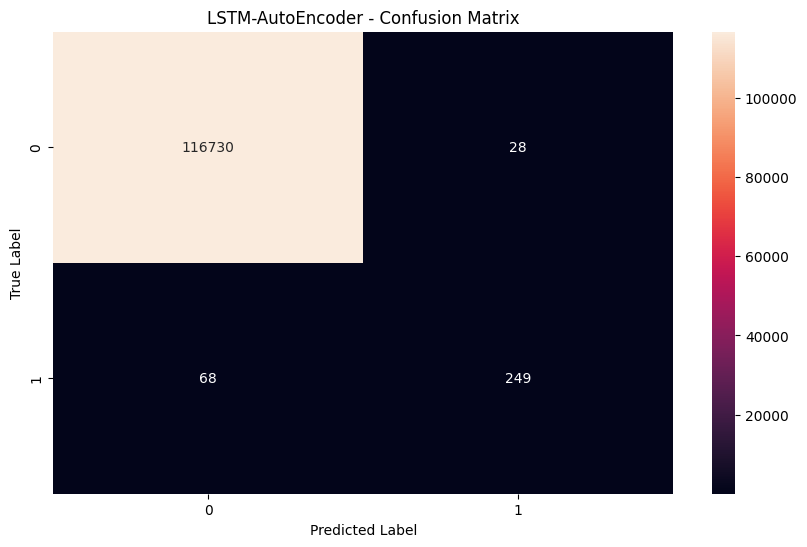

In [121]:
threshold = threshold_15S
set_threshold(y_test_15S, test_mae_15S, threshold)

- 5S

Epoch 1/150
18473/18473 [==============================] - 50s 2ms/step - loss: 0.1479 - val_loss: 0.0807
Epoch 2/150
18473/18473 [==============================] - 44s 2ms/step - loss: 0.0453 - val_loss: 0.0351
Epoch 3/150
18473/18473 [==============================] - 43s 2ms/step - loss: 0.0356 - val_loss: 0.0342
Epoch 4/150
18473/18473 [==============================] - 44s 2ms/step - loss: 0.0348 - val_loss: 0.0361
Epoch 5/150
18473/18473 [==============================] - 43s 2ms/step - loss: 0.0341 - val_loss: 0.0335
Epoch 6/150
18473/18473 [==============================] - 44s 2ms/step - loss: 0.0310 - val_loss: 0.0238
Epoch 7/150
18473/18473 [==============================] - 44s 2ms/step - loss: 0.0225 - val_loss: 0.0228
Epoch 8/150
18473/18473 [==============================] - 45s 2ms/step - loss: 0.0212 - val_loss: 0.0205
Epoch 9/150
18473/18473 [==============================] - 44s 2ms/step - loss: 0.0206 - val_loss: 0.0226
Epoch 10/150
18473/18473 [====================

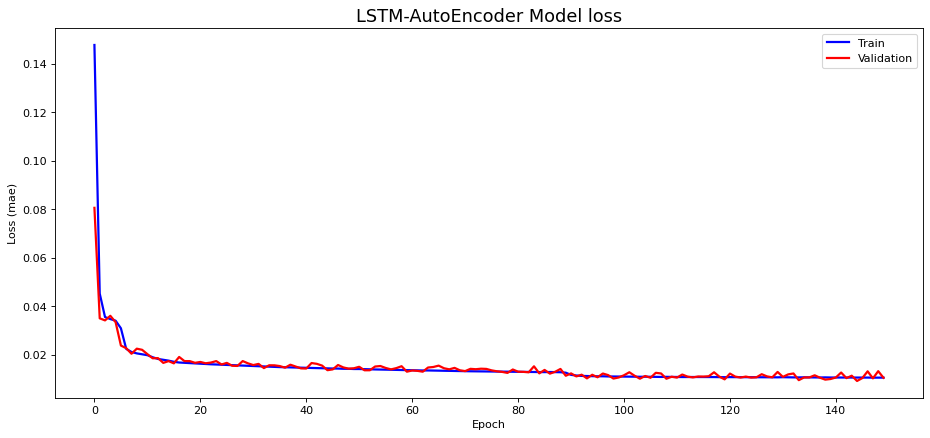

5142/5142 [==============================] - 5s 844us/step


In [122]:
autoencoder_5S, test_mae_5S, y_test_5S = lstm_autoencoder(time_freq='5S')

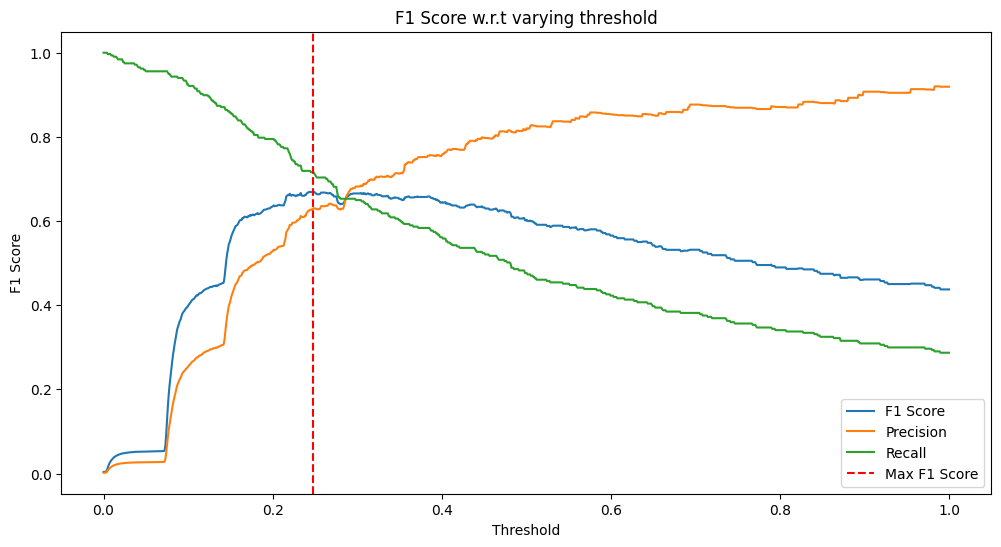

Best threshold:  0.24824824824824826
Best F1 Score:  0.6706056129985228
Recall:  0.7160883280757098
Precision:  0.6305555555555555


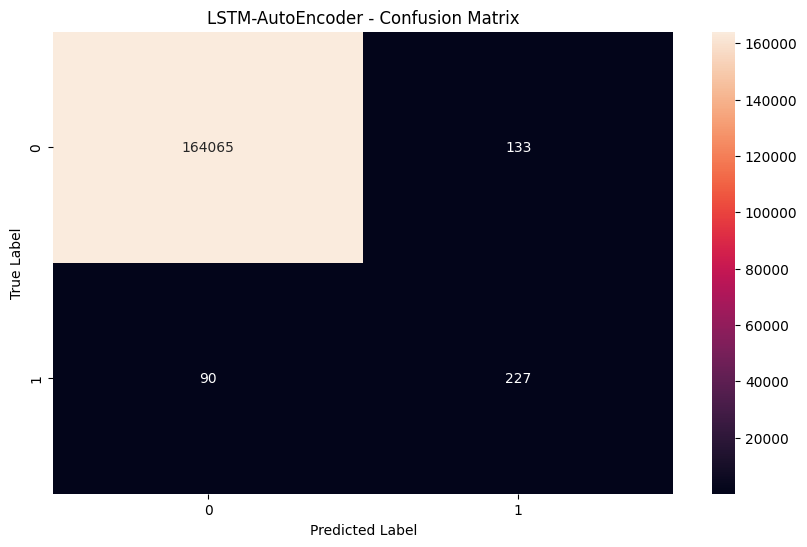

In [123]:
threshold_5S = pick_threshold(y_test_5S, test_mae_5S)

Reconstruction error threshold:  0.24824824824824826
F1 score: 0.6706056129985228
Recall: 0.7160883280757098
Precision: 0.6305555555555555


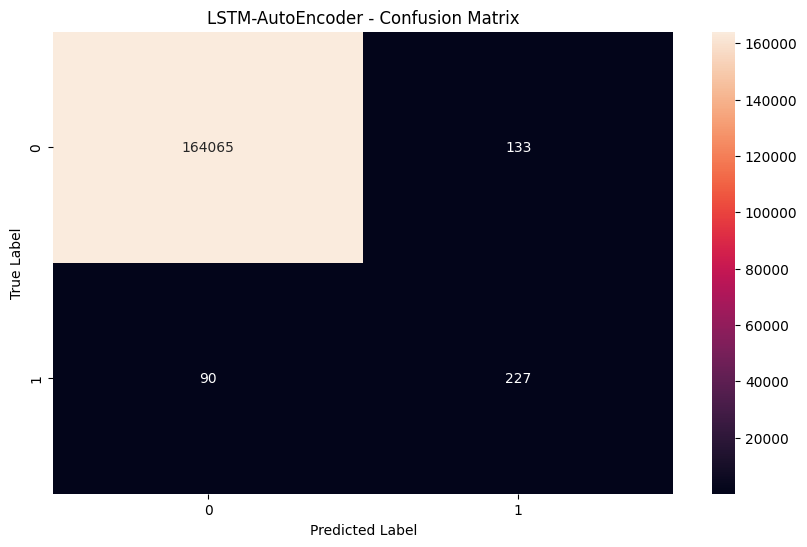

In [124]:
threshold = threshold_5S
set_threshold(y_test_5S, test_mae_5S, threshold_5S)

In [ ]:
# # 设置阈值
# threshold_1 = np.mean(test_mae_loss) + 3 * np.std(test_mae_loss)
# threshold_2 = np.mean(test_mae_loss) - 3 * np.std(test_mae_loss)
# print("Reconstruction error threshold: ", threshold_1, threshold_2)
# y_test_pred = np.where((test_mae_loss >= threshold_1) | (test_mae_loss< threshold_2) , 1, 0)

# # precision, recall, f1-score
# print('Recall: {}'.format(recall_score(y_test, y_test_pred)))
# print('Precision: {}'.format(precision_score(y_test, y_test_pred)))
# print('F1 score: {}'.format(f1_score(y_test, y_test_pred)))

# # plot confusion matrix
# from sklearn.metrics import confusion_matrix
# cm = confusion_matrix(y_test, y_test_pred)
# plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d')
# plt.title('LSTM-AutoEncoder - Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

### MAD-GAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

In [ ]:
# Generator model
def build_generator(latent_dim, timesteps, features):
    model = models.Sequential()
    model.add(layers.LSTM(100, input_shape=(latent_dim, 1)))
    model.add(layers.RepeatVector(timesteps))
    model.add(layers.LSTM(100, return_sequences=True))
    model.add(layers.TimeDistributed(layers.Dense(features, activation='tanh')))
    return model

# Discriminator model
def build_discriminator(timesteps, features):
    model = models.Sequential()
    model.add(layers.Input(shape=(timesteps, features)))
    model.add(layers.LSTM(100))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Combine generator and discriminator to form MAD-GAN
def build_madgan(generator, discriminator):
    model = models.Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

# Parameters
latent_dim = 100
timesteps = 300
features = 12

# Create instances of generator and discriminator
generator = build_generator(latent_dim, timesteps, features)
discriminator = build_discriminator(timesteps, features)

# Build MAD-GAN
madgan = build_madgan(generator, discriminator)
madgan.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test(time_freq='25S')

In [ ]:
# Compile MAD-GAN
opt = optimizers.Adam(lr=0.0002, beta_1=0.5)
madgan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train MAD-GAN
epochs = 100
batch_size = 32
for epoch in range(epochs):
    

1

In [ ]:
# timestamps
def to_sequences(x,y,seq_size):
    x = pd.DataFrame(x)
    y = pd.Series(y)
    x_values = []
    y_values = []
    for i in range(len(x)-seq_size):
        x_values.append(x.iloc[i:(i+seq_size)].values)
        y_values.append(y.iloc[i+seq_size])
    return np.array(x_values), np.array(y_values)

seq_size=30
trainX, trainY = to_sequences(X_train,y_train,seq_size)
testX, testY = to_sequences(X_test,y_test,seq_size)